In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import qutip
import scqubits
from scipy.optimize import minimize
from scipy.integrate import quad
from time import time
from tqdm import tqdm
from datetime import datetime

In [2]:
# Parameters
anharmonicity = -0.3109*2*np.pi   # GHz
omega_d = 4.7331*2*np.pi          # Driving frequency in GHz
N = 8                     # Number of levels in the transmon
# gamma = 0.05            # Dissipation rate
T = 96                    # Pulse duration
beta = 0.03
tau = 10
P = 10
T1 = T / 100
# Operators
a = qutip.destroy(N)
# H0 = omega_d * (a.dag() * a + 0.5 * qeye(N)) + anharmonicity * a.dag()**2 * a**2

In [3]:
def drag_pulse(t, args):
    """
    DRAG pulse shape: Gaussian pulse with derivative
    """
    sigma = args['sigma']
    A = args['A']
    delta = args['delta']
    T = args['T']
    # return A * np.exp(-((t - T / 2) ** 2) / (2 * sigma ** 2)) * (1 + 1j * delta * (t - T / 2) / (sigma ** 2))
    return A * np.heaviside(t, 0) * np.heaviside(T-t, 0) * np.exp(-((t - T/2) ** 2) / (2 * sigma ** 2)) / (np.cos(np.arctan(delta * (t - T/2) / sigma ** 2)))
    
def drag_delta(t, args):
    """
    DRAG detuning shape: Lorentzian pulse with additive constant
    """
    sigma = args['sigma']
    A = args['A']
    delta = args['delta']
    T = args['T']
    d = args['d']
    # return A * np.exp(-((t - t0) ** 2) / (2 * sigma ** 2)) * (1 + 1j * delta * (t - t0) / (sigma ** 2))
    return (d + (delta / sigma ** 2) / (1 + (delta * (t - T/2) / sigma ** 2) ** 2)) * np.heaviside(t, 0) * np.heaviside(T-t, 0)


def rectangular_pulse(t, args):
    """
    Rectangular pulse shape: Constant pulse turned on at t=0 and off at t=T
    """
    A = args['A']
    T = args['T']
    return A * np.heaviside(t, 0) * np.heaviside(T - t, 0)

def rect_delta(t, args):
    """
    Rectangular detuning shape: Constant
    """
    T = args['T']
    return args['d'] * np.heaviside(t, 0) * np.heaviside(T - t, 0)


def fcq_pulse(t, args):
    """
    Face-changing quadratic (FCQ) pulse shape: A constant with added/subtracted quadratic
    """
    A = args['A']
    T = args['T']
    return A * (1 + args["beta"] * (((t - T/2) / (T/2)) ** 2 - 1)) * np.heaviside(t, 0) * np.heaviside(T - t, 0)

def fcq_delta(t, args):
    """
    Face-changing quadratic (FCQ) detuning shape: Constant
    """
    T = args['T']
    return args['d'] * np.heaviside(t, 0) * np.heaviside(T - t, 0)


def ee_pulse(t, args):
    """
    Even-exponent (ee) pulse shape: An even-exponent of time
    """
    A = args['A']
    T = args['T']
    return A * ((t - T/2) / (T/2)) ** (2 * args["P"]) * np.heaviside(t, 0) * np.heaviside(T - t, 0)

def ee_delta(t, args):
    """
    Even-exponent (ee) detuning shape: Constant
    """
    T = args['T']
    return args['d'] * np.heaviside(t, 0) * np.heaviside(T - t, 0)


def lz_pulse(t, args):
    """
    Landau-Zener pulse shape: Phase-modulated constant Rabi
    """
    A = args['A']
    T = args['T']
    return A * np.heaviside(t, 0) * np.heaviside(T - t, 0)

def lz_delta(t, args):
    """
    Landau-Zener detuning shape: Constant
    """
    T = args['T']
    return args["beta"] * (t - T/2) * np.heaviside(t, 0) * np.heaviside(T - t, 0)


def ae_pulse(t, args):
    """
    Allen-Eberly pulse shape: Phase-modulated constant Rabi
    """
    A = args['A']
    T = args['T']
    return A * np.exp(- 1j * args["beta"] * args["tau"] * np.log(np.cos((t - T / 2) / args["tau"]))) * np.heaviside(t, 0) * np.heaviside(T - t, 0)

def ae_delta(t, args):
    """
    Allen-Eberly detuning shape: Constant
    """
    T = args['T']
    return 0 * np.heaviside(t, 0) * np.heaviside(T - t, 0)


def dk2_pulse(t, args):
    """
    Demkov-Kunike-2 pulse shape: Phase-modulated constant Rabi
    """
    A = args['A']
    T = args['T']
    return A * np.exp(1j * args["beta"] * args["tau"] * np.log(np.cosh((t - T / 2) / args["tau"]))) * np.heaviside(t, 0) * np.heaviside(T - t, 0)

def dk2_delta(t, args):
    """
    Demkov-Kunike-2 detuning shape: Constant
    """
    T = args['T']
    return 0 * np.heaviside(t, 0) * np.heaviside(T - t, 0)


def ramsey_pulse(t, args):
    """
    Ramsey pulse shape: two brief pulses separated long time apart
    """
    A = args['A']
    T = args['T']
    T1 = args['T1']
    
    return A * (np.heaviside(t, 0) * np.heaviside(T1 - t, 0) + np.heaviside(t - (T - T1), 0) * np.heaviside(T - t, 0)) * np.heaviside(t, 0) * np.heaviside(T - t, 0)

def ramsey_delta(t, args):
    """
    Ramsey pulses detuning shape: Constant
    """
    T = args['T']
    return args['d'] * np.heaviside(t, 0) * np.heaviside(T - t, 0)

    
def sinusoidal_pulse(t, args):
    """
    Sinusoidal pulse shape: First half-period of a sine wave
    """
    A = args['A']
    T = args['T']
    d = args['d']
    return A * np.sin(np.pi * t / T) * np.heaviside(t, 0) * np.heaviside(T-t, 0)

def sine_delta(t, args):
    """
    Sine detuning shape: Constant
    """
    return args['d'] * np.heaviside(t, 0) * np.heaviside(args["T"] - t, 0)


def hamiltonian_drive(pulse_func, delta_func, args):
    """
    Construct the time-dependent Hamiltonian for the given pulse shape
    """
    transmon = scqubits.Transmon(
    # EJ=11.77673876,
    # EC=0.26715723,
    EJ=73.99540383,
    EC=1.67859904,
    ng=0,
    ncut=31,
    truncated_dim=8)    
    
    H0 = np.insert(np.diff(np.diag(transmon.hamiltonian(True))) - omega_d, 0, [0])
    H0 = np.diag(H0)
    #     H0 += np.diag(np.ones(8) * args["d"])
    
    
    H1 = transmon.n_operator(True)
    H1 /= H1[0,1]
    H1 /= 2

    H2 = np.diag(np.ones(8))
    H2[0,0] = 0
    
    H = [qutip.Qobj(H0), [qutip.Qobj(H1), pulse_func], [qutip.Qobj(H2), delta_func]]
    return H


def run_simulation(
    pulse_func, delta_func, 
    tlist, sigma,
    d_min, d_max, d_num,
    A_min, A_max, A_num
):
    """
    Run the time evolution simulation for the given pulse function and parameters
    """
    
    options = {}
    options['nsteps'] = 5000
    psi0 = qutip.basis(N, 0) * qutip.basis(N, 0).dag()  # initial state: ground state
    # result = mesolve(H, psi0, tlist, [], [basis(N, i) * basis(N, i).dag() for i in range(N)], args=pulse_args)
    d_range = np.linspace(d_min, d_max, d_num)
    A_range = np.linspace(A_min, A_max, A_num)
    tr_probs = []

    # Loop with progress bar
    # for i in tqdm(range(d_num), desc="Driving system with Hamiltonian", unit="iteration", ncols=100, ascii=True, colour='green'):
    for n_d, d in enumerate(d_range):
        values = []
        # t0 = time()
        for n_A, A in enumerate(A_range):
            pulse_args = {'sigma': sigma, 'A': A, 't0': T / 2, 'delta': 1 / (anharmonicity), 'd': d, 'T': T, 'N': N, 'beta': beta, 'tau': tau, 'P': P, 'T1': T1}
            H = hamiltonian_drive(pulse_func, delta_func, pulse_args)
            output = qutip.mesolve(
                H, psi0,
                args=pulse_args,
                tlist=tlist,
                options=options
            )
            values.append(output.states[-1])
        tr_probs.append(values)
        # print(time() - t0)

    return tr_probs

In [4]:
def calculate_areas():
    pulse_args = {'sigma': T/10, 'A': 1, 't0': T / 2, 'delta': 1 / (anharmonicity), 'd': 0, 'T': T, 'N': N, 'beta': beta, 'tau': tau, 'P': P, "T1": T1}
#     t = np.linspace(0,T,1000)
#     f = drag_pulse(t, pulse_args)
#     plt.plot(t, f)
#     plt.show()
    drag_area = quad(lambda t: drag_pulse(t, pulse_args), 0, pulse_args["T"], limit=200)
    rect_area = quad(lambda t: rectangular_pulse(t, pulse_args), 0, pulse_args["T"], limit=200)
    fcq_area = quad(lambda t: fcq_pulse(t, pulse_args), 0, pulse_args["T"], limit=200)
    ee_area = quad(lambda t: ee_pulse(t, pulse_args), 0, pulse_args["T"], limit=200)
    lz_area = quad(lambda t: lz_pulse(t, pulse_args), 0, pulse_args["T"], limit=200)
    ae_area = quad(lambda t: ae_pulse(t, pulse_args), 0, pulse_args["T"], limit=200)
    dk2_area = quad(lambda t: dk2_pulse(t, pulse_args), 0, pulse_args["T"], limit=200)
    ramsey_area = quad(lambda t: ramsey_pulse(t, pulse_args), 0, pulse_args["T"], limit=200)
    sine_area = quad(lambda t: sinusoidal_pulse(t, pulse_args), 0, pulse_args["T"], limit=200)
    return drag_area, rect_area, fcq_area, ee_area, lz_area, ae_area, dk2_area, ramsey_area, sine_area

drag, rect, fcq, ee, lz, ae, dk2, ramsey, sine = calculate_areas()
drag_area, drag_area_err = drag
rect_area, rect_area_err = rect
fcq_area, fcq_area_err = fcq
ee_area, ee_area_err = ee
lz_area, lz_area_err = lz
ae_area, ae_area_err = ae
dk2_area, dk2_area_err = dk2
ramsey_area, ramsey_area_err = ramsey
sine_area, sine_area_err = sine
A_sine_max2 = 10 * np.pi**2 / (2*T)
print(A_sine_max2)
A_drag_max = 10 * np.pi / drag_area
A_rect_max = 10 * np.pi / rect_area
A_fcq_max = 10 * np.pi / fcq_area
A_ee_max = 10 * np.pi / ee_area
A_lz_max = 10 * np.pi / lz_area
A_ae_max = 10 * np.pi / ae_area
A_dk2_max = 10 * np.pi / dk2_area
A_ramsey_max = 10 * np.pi / ramsey_area
A_sine_max = 10 * np.pi / sine_area
A_drag_max, A_rect_max, A_fcq_max, A_ee_max, A_lz_max, A_ae_max, A_dk2_max, A_ramsey_max, A_sine_max
# pulse_args = {'sigma': T/10, 'A': A_drag_max, 't0': T / 2, 'delta': 1 / (anharmonicity), 'd': 0, 'T': T, 'N': N}
# t = np.linspace(0,T,1000)
# f = drag_pulse(t, pulse_args)
# plt.plot(t, f)
# plt.show()
# g = drag_delta(t, pulse_args)
# plt.plot(t, g)
# plt.show()

0.5140418958900708


 C:\Miniconda3\envs\quantum2\Lib\site-packages\scipy\integrate\_quadpack_py.py: 606RuntimeWarning: invalid value encountered in log
 C:\Users\Ivo\AppData\Local\Temp\ipykernel_4968\13954755.py: 95IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 C:\Users\Ivo\AppData\Local\Temp\ipykernel_4968\771774899.py: 12

(1.3036867304289093,
 0.3272492347489368,
 0.3339277905601396,
 6.87223392972767,
 0.3272492347489368,
 nan,
 0.41004289121500476,
 16.362461737446836,
 0.5140418958900708)

In [8]:
# Simulation parameters
tlist = np.linspace(0, T, 100)  # Time grid
d_min, d_max, d_num = (-0.5, 0.5, 46)
A_min, A_num = (0, 45)
tlist = np.linspace(0, T, 100)  # Time grid
d_min, d_max, d_num = (-5, 5, 46)
A_min, A_num = (0, 45)

# Run simulations
# result_drag = run_simulation(drag_pulse, drag_delta, tlist, T/10, d_min, d_max, d_num, A_min, A_drag_max, A_num)
# result_rect = run_simulation(rectangular_pulse, rect_delta, tlist, T/10, d_min, d_max, d_num, A_min, A_rect_max, A_num)
# result_fcq = run_simulation(fcq_pulse, fcq_delta, tlist, T/10, d_min, d_max, d_num, A_min, A_fcq_max, A_num)
result_ee = run_simulation(ee_pulse, ee_delta, tlist, T/10, d_min, d_max, d_num, A_min, A_ee_max, A_num)
result_ramsey = run_simulation(ramsey_pulse, ramsey_delta, tlist, T/10, d_min, d_max, d_num, A_min, A_ramsey_max, A_num)
# result_lz = run_simulation(lz_pulse, lz_delta, tlist, T/10, d_min, d_max, d_num, A_min, 10, A_num)
# result_ae = run_simulation(ae_pulse, ae_delta, tlist, T/10, d_min, d_max, d_num, A_min, A_ae_max, A_num)
# result_dk2 = run_simulation(dk2_pulse, dk2_delta, tlist, T/10, d_min, d_max, d_num, A_min, A_dk2_max, A_num)
# result_sinusoidal = run_simulation(sinusoidal_pulse, sine_delta, tlist, T/10, d_min, d_max, d_num, A_min, A_sine_max, A_num)

In [ ]:
def leakage(result_optim):
    leakage_values = []
    for res in result_optim:
        leakage_line = []
        for r in res:
            leakage = 0
            for d in range(2, N):
                leakage += np.abs(r[d,d])
            leakage_line.append(leakage)
        leakage_values.append(leakage_line)
    return np.array(leakage_values)

tlist = np.linspace(0, T, 100)  # Time grid
d_min, d_max, d_num = (-0.22, 0.22, 101)
A_min, A_num = (0, 100)
sigmas, tr_probs, leakages, drags, results = ([T/2, T/4, T/8, T/16], [], [], [], [])
for sig in sigmas:
    pulse_args = {'sigma': sig, 'A': 1, 't0': T / 2, 'delta': 1 / (anharmonicity), 'd': 0, 'T': T, 'N': N}
    drag = [drag_pulse(tlist, pulse_args), drag_delta(tlist, pulse_args)]
    drag_area = quad(lambda t: drag_pulse(t, pulse_args), 0, pulse_args["T"])
    drags.append(drag)
    A_drag = 10* np.pi / drag_area[0]
    rd = run_simulation(drag_pulse, drag_delta, tlist, sig, d_min, d_max, d_num, A_min, A_drag, A_num)
    tp_drag = np.array([[np.abs(r[1,1]) for r in res] for res in rd])[::-1]
    tr_probs.append(tp_drag)
    leakages.append(leakage(rd))
    results.append(rd)


In [ ]:
d_range = np.linspace(d_min, d_max, d_num)
A_drag_range = np.linspace(A_min, A_drag_max, A_num)
tr_probs_drag = np.array([[np.abs(r[1,1]) for r in res] for res in result_drag])[::-1]
# print(tr_probs)
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_drag_range, tr_probs_drag.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Transition Probability')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Transition Probability for DRAG Pulse')
plt.show()


In [ ]:
d_range = np.linspace(d_min, d_max, d_num)
A_rect_range = np.linspace(A_min, A_rect_max, A_num)
tr_probs_rect = np.array([[np.abs(r[1,1]) for r in res] for res in result_rect])[::-1]
# print(tr_probs)
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_rect_range, tr_probs_rect.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Transition Probability')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Transition Probability for Rectangular Pulse')
plt.show()


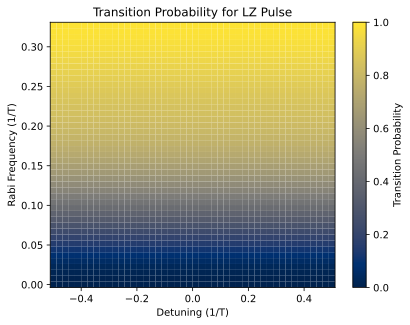

In [19]:
d_range = np.linspace(d_min, d_max, d_num)
A_lz_range = np.linspace(A_min, A_lz_max, A_num)
tr_probs_lz = np.array([[np.abs(r[1,1]) for r in res] for res in result_lz])[::-1]
# print(tr_probs)
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_lz_range, tr_probs_lz.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Transition Probability')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Transition Probability for LZ Pulse')
plt.show()


In [6]:
d_range = np.linspace(d_min, d_max, d_num)
A_fcq_range = np.linspace(A_min, A_fcq_max, A_num)
tr_probs_fcq = np.array([[np.abs(r[1,1]) for r in res] for res in result_fcq])[::-1]
# print(tr_probs)
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_fcq_range, tr_probs_fcq.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Transition Probability')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Transition Probability for FCQ Pulse')
dt = datetime.now()
date = dt.strftime("%Y-%m-%d")
tm = dt.strftime("%H%M%S")
plt.savefig(f"C:/Users/Ivo/Desktop/face-changing_quadratic_{date}_{tm}.pdf")

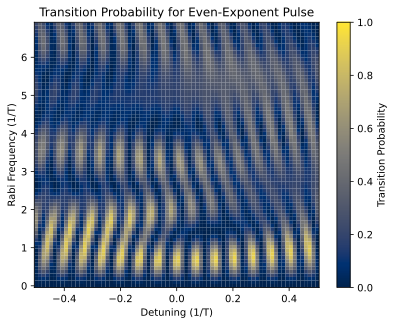

In [7]:
d_range = np.linspace(d_min, d_max, d_num)
A_ee_range = np.linspace(A_min, A_ee_max, A_num)
tr_probs_ee = np.array([[np.abs(r[1,1]) for r in res] for res in result_ee])[::-1]
# print(tr_probs)
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_ee_range, tr_probs_ee.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Transition Probability')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Transition Probability for Even-Exponent Pulse')
dt = datetime.now()
date = dt.strftime("%Y-%m-%d")
tm = dt.strftime("%H%M%S")
plt.savefig(f"C:/Users/Ivo/Desktop/even_exponent_{date}_{tm}.pdf")

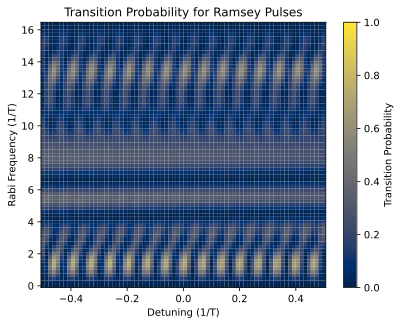

In [8]:
d_range = np.linspace(d_min, d_max, d_num)
A_ramsey_range = np.linspace(A_min, A_ramsey_max, A_num)
tr_probs_ramsey = np.array([[np.abs(r[1,1]) for r in res] for res in result_ramsey])[::-1]
# print(tr_probs)
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_ramsey_range, tr_probs_ramsey.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Transition Probability')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Transition Probability for Ramsey Pulses')
dt = datetime.now()
date = dt.strftime("%Y-%m-%d")
tm = dt.strftime("%H%M%S")
plt.savefig(f"C:/Users/Ivo/Desktop/ramsey_{date}_{tm}.pdf")


In [ ]:
tr_probs_sin = np.array([[np.abs(r[1,1]) for r in res] for res in result_sinusoidal])[::-1]
A_sine_range = np.linspace(A_min, A_sine_max, A_num)
print(tr_probs_sin.shape)
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_sine_range, tr_probs_sin.T, vmin=0, vmax=1, cmap=cmap)
fig.colorbar(im, ax=ax, label='Transition Probability')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Transition Probability for Sine Pulse')
plt.show()


In [ ]:
# leakage = np.array([[[np.abs(r[d,d]) for d in range(2,8)] for r in res] for res in result_drag])

def leakage(result_optim):
    leakage_values = []
    for res in result_optim:
        leakage_line = []
        for r in res:
            leakage = 0
            for d in range(2, N):
                leakage += np.abs(r[d,d])
            leakage_line.append(leakage)
        leakage_values.append(leakage_line)
    return np.array(leakage_values)
    
leakage_drag = leakage(result_drag)[::-1]
leakage_rect = leakage(result_rect)[::-1]
leakage_sine = leakage(result_sinusoidal)[::-1]


In [ ]:
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_drag_range, leakage_drag.T, vmin=0, vmax=1e-7, cmap=cmap)
fig.colorbar(im, ax=ax, label='Leakage')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Leakage for DRAG Pulse')
plt.show()

In [ ]:
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_rect_range, leakage_rect.T, vmin=0, vmax=1e-2, cmap=cmap)
fig.colorbar(im, ax=ax, label='Leakage')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Leakage for Rectangular Pulse')
plt.show()

In [ ]:
# Create pcolormesh plot
fig, ax = plt.subplots(1,1)
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im = ax.pcolormesh(d_range, A_sine_range, leakage_sine.T, vmin=0, vmax=5e-6, cmap=cmap)
fig.colorbar(im, ax=ax, label='Leakage')
plt.ylabel('Rabi Frequency (1/T)')
plt.xlabel('Detuning (1/T)')
plt.title('Leakage for Sine Pulse')
plt.show()

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

# Pulse shapes on 1st row
for i in range(4):
    axs[0, i].plot(tlist, drags[i][0])
    axs[0, i].legend(title=f'Pulse shape {i+1}')
    if i == 0: 
        axs[0, i].set_ylabel("Rabi Frequency ($\\Omega$")
    axs[0, i].set_xlabel("Time (t)")
    
axs[0, 4].plot(tlist, sinusoidal_pulse(tlist, pulse_args))
axs[0, 4].legend(title=f'Pulse shape {5}')
axs[0, 4].set_xlabel("Time (t)")

sigmas, As = [T/2, T/4, T/8, T/16], []
for sig in sigmas:
    pulse_args = {'sigma': sig, 'A': 1, 't0': T / 2, 'delta': 1 / (anharmonicity), 'd': 0, 'T': T, 'N': N}
    drag = [drag_pulse(tlist, pulse_args), drag_delta(tlist, pulse_args)]
    drag_area = quad(lambda t: drag_pulse(t, pulse_args), 0, pulse_args["T"])
    As.append( 10* np.pi / drag_area[0])

# Pcolormesh on the second row
for i in range(4):
    A_range = np.linspace(0, As[i], 100)
    c = axs[1, i].pcolormesh(d_range, A_range, tr_probs[i].T, cmap='cividis')
    fig.colorbar(c, ax=axs[1, i])
    axs[1, i].legend(title=f'Tr. Prob. {i+1}')
    
A_range = np.linspace(0, A_sine_max, 100)
c = axs[1, 4].pcolormesh(d_range, A_sine_range, tr_probs_sin.T, cmap='cividis')
fig.colorbar(c, ax=axs[1, 4])
axs[1, 4].legend(title=f'Tr. Prob. {5}')

for i in range(4):
    A_range = np.linspace(0, As[i], 100)
    c = axs[2, i].pcolormesh(d_range, A_range, leakages[i].T, cmap='cividis')
    fig.colorbar(c, ax=axs[2, i])
    axs[2, i].legend(title=f'Leakage {i+1}')

A_range = np.linspace(0, A_sine_max, 100)
c = axs[2, 4].pcolormesh(d_range, A_sine_range, leakage_sine.T, cmap='cividis')
fig.colorbar(c, ax=axs[2, 4])
axs[2, 4].legend(title=f'Leakage {5}')
    

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
times = {
    "sq": ["2023-12-08", "175156"],
    "sin": ["2023-12-08", "130503"],
}
backend_name = "kyoto"
save_fig = 0
save_fig = 1
file_dir = os.path.dirname(__file__) + "/.."

def data_folder(date, time, pulse_type):
    return os.path.join(
        file_dir,
        "data",
        f"{backend_name}",
        "power_broadening (narrowing)",
        f"{pulse_type}_pulses",
        date,
        time
    ).replace("\\", "/")

l, p, x0 = 1.25116799e+02, 3.01445760e-01, 8.23116906e-03
T = 192 * 5e-10
tr_prob, amp, det = [], [], []
for k, t in times.items():
    files = os.listdir(data_folder(t[0], t[1], k))
    with open(os.path.join(data_folder(t[0], t[1], k), files[2]).replace("\\","/"), 'rb') as f1:
        tr_prob.append(pickle.load(f1))
    with open(os.path.join(data_folder(t[0], t[1], k), files[0]), 'rb') as f2:
        amp.append(l * (1 - np.exp(-p * (pickle.load(f2) - x0))) / (1e6 * (2*T/np.pi)))
    with open(os.path.join(data_folder(t[0], t[1], k), files[1]), 'rb') as f3:
        det.append(pickle.load(f3) * 2 * np.pi / 1e6)

with open("C:/Users/Ivo/Documents/qiskit_experiments/sine.pkl", "rb") as f1:
    data = pickle.load(f1)
interval_det, interval_amp = [100, 100], [100, 150]
lim_det, lim_amp = [230, 230], [300, 500]#490]
det.append(np.arange(-2.3e2, 2.3001e2, 0.05e2))
amp.append(np.arange(0, 5.001e2, 2.5))
# tr_prob.append(data[:, 2].reshape(len(det[2]), len(amp[2])).T)
tr_prob.append(data)

# data_sq = pd.read_csv("C:/Users/Ivo/Documents/qiskit_experiments/sq.csv", header=None).to_numpy()
with open("C:/Users/Ivo/Documents/qiskit_experiments/sq.pkl", "rb") as f2:
    data_sq = pickle.load(f2)
det.insert(1, np.arange(-2.3e2, 2.3001e2, 0.025e2))
amp.insert(1, np.arange(0, 3.20001e2, 1))
tr_prob.insert(1, data_sq)#[:, 2].reshape(len(det[1]), len(amp[1])).T)


In [26]:
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
with open("./pulse_optimisation/result_fcq_2024-12-17_102632.pkl", "rb") as f:
    result_fcq = pickle.load(f)
with open("./pulse_optimisation/result_ee_2024-12-17_102632.pkl", "rb") as f:
    result_ee = pickle.load(f)
with open("./pulse_optimisation/result_ramsey_2024-12-17_102632.pkl", "rb") as f:
    result_ramsey = pickle.load(f)
A_ee_max, A_ramsey_max = 6.87223392972767, 16.362461737446836
d_min, d_max, d_num = (-0.5, 0.5, 76)
A_min, A_num = (0, 75)   

d_range = np.linspace(d_min, d_max, d_num)
A_ee_range = np.linspace(A_min, A_ee_max, A_num)
A_ramsey_range = np.linspace(A_min, A_ramsey_max, A_num)
tr_probs_ee = np.array([[np.abs(r[1,1]) for r in res] for res in result_ee])[::-1]
tr_probs_ramsey = np.array([[np.abs(r[1,1]) for r in res] for res in result_ramsey])[::-1]

# Create the grid of two horizontal plots
fig, axes = plt.subplots(1, 2, figsize=(11, 5), width_ratios=[1,1])  # 1 row, 3 columns

font_size = 15
# First plot
cmap = matplotlib.colormaps["cividis"]  # Choose a colormap
im1 = axes[0].pcolormesh(d_range, A_ee_range, tr_probs_ee.T, vmin=0, vmax=1, cmap=cmap)
# fig.colorbar(im1, ax=axes[0], label='Transition Probability')
axes[0].set_ylabel('Rabi Frequency (1/T)', fontsize=font_size)
axes[0].set_xlabel('Detuning (1/T)', fontsize=font_size)
axes[0].legend(title='Even-Exponent Pulse', title_fontsize=font_size)
axes[0].tick_params(labelsize=font_size)

# Second plot - placeholder
im2 = axes[1].pcolormesh(d_range, A_ramsey_range, tr_probs_ramsey.T, vmin=0, vmax=1, cmap=cmap)
# fig.colorbar(im2, ax=axes[1], label='Transition Probability')
# axes[1].set_ylabel('Rabi Frequency (1/T)')
axes[1].set_xlabel('Detuning (1/T)', fontsize=font_size)
axes[1].legend(title='Ramsey Pulses', title_fontsize=font_size)
axes[1].tick_params(labelsize=font_size)
# cbar = fig.colorbar(im2, cax=axes[2])
# cbar.ax.tick_params(labelsize=font_size)
# Attach a colorbar to the second axis with a custom pad.
divider = make_axes_locatable(axes[1])
# Here, 'size' controls the width of the colorbar and 'pad' sets the gap between ax2 and the colorbar.
cax = divider.append_axes("right", size="6%", pad=0.1)  # adjust pad value as needed
cbar = fig.colorbar(im2, cax=cax)
cbar.ax.tick_params(labelsize=font_size)

# Adjust layout
plt.tight_layout()
plt.savefig("C:/Users/Ivo/Desktop/ramsey_vs_P10.pdf")



 C:\Users\Ivo\AppData\Local\Temp\ipykernel_4968\409583879.py: 29UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 C:\Users\Ivo\AppData\Local\Temp\ipykernel_4968\409583879.py: 37

In [9]:
import os
from datetime import datetime
import pickle
current_dir = os.getcwd()
dt_now = datetime.now()
time = dt_now.strftime("%H%M%S")
date = dt_now.strftime("%Y-%m-%d")

# with open(f"./pulse_optimisation/result_drag_{date}_{time}.pkl", "wb") as f:
#     pickle.dump(result_drag, f)
# with open(f"./pulse_optimisation/result_rect_{date}_{time}.pkl", "wb") as f:
#     pickle.dump(result_rect, f)
# with open(f"./pulse_optimisation/result_sine_{date}_{time}.pkl", "wb") as f:
#     pickle.dump(result_sinusoidal, f)
with open(f"./pulse_optimisation/result_fcq_{date}_{time}.pkl", "wb") as f:
    pickle.dump(result_fcq, f)
with open(f"./pulse_optimisation/result_ee_{date}_{time}.pkl", "wb") as f:
    pickle.dump(result_ee, f)
with open(f"./pulse_optimisation/result_ramsey_{date}_{time}.pkl", "wb") as f:
    pickle.dump(result_ramsey, f)

In [ ]:
import os
from datetime import datetime
import pickle
current_dir = os.getcwd()
dt_now = datetime.now()
time = dt_now.strftime("%H%M%S")
date = dt_now.strftime("%Y-%m-%d")

with open(f"./pulse_optimisation/result_drag_{date}_{time}.pkl", "wb") as f:
    pickle.dump(result_drag, f)
with open(f"./pulse_optimisation/result_rect_{date}_{time}.pkl", "wb") as f:
    pickle.dump(result_rect, f)
with open(f"./pulse_optimisation/result_sine_{date}_{time}.pkl", "wb") as f:
    pickle.dump(result_sinusoidal, f)

In [ ]:
with open(f"./pulse_optimisation/result_sine_{date}_{time}.pkl", "rb") as f:
    rs = pickle.load(f)


In [ ]:
# Define the objective function to be optimized
def objective_function(params):
    transmon = scqubits.Transmon(EJ=params[0],
                                 EC=params[1],
                                 ng=0,
                                 ncut=31,
                                 truncated_dim=8)
    exc_energies = np.diff(transmon.eigenvals())
    anharm = np.diff(exc_energies)[0]
    return (exc_energies[0] - obj_energy)**2 + (anharm - obj_anharm)**2


In [ ]:
initial_guess = [10, 0.2]
obj_energy, obj_anharm = 4.7331*2*np.pi, -0.3109*2*np.pi
bounds = [(0, 100), (0, 100)]
result = minimize(objective_function, initial_guess, bounds=bounds)
# Print the optimization result
print("Optimization Result:")
print("Success:", result.success)
print("Message:", result.message)
print("Optimal Parameters:", result.x)
print("Objective Function Value at Optimum:", result.fun)

In [ ]:
transmon = scqubits.Transmon(
    
    EJ=13.30993317,
    EC=0.26147263,
    ng=0,
    ncut=31,
    truncated_dim=8)    
exc_energies = np.diff(transmon.eigenvals())
anharm = np.diff(exc_energies)[0]
print(transmon.eigenvals())
print(exc_energies)
print(transmon.n_operator(True))
ham = np.diff(np.diag(transmon.hamiltonian(True))) + np.ones(7) * -5
ham = np.diag(np.insert(ham, 0, [0]))
print(ham)

In [ ]:
import scqubits as scq
import numpy as np
import matplotlib.pyplot as plt

# Define transmon parameters
Ej = 13.30993317  # Josephson energy in GHz
Ec = 0.26147263   # Charging energy in GHz
ng = 0.0          # Offset charge
ncut = 31         # Charge basis truncation
trunc = 8         # Truncation of the transmon Hilbert space

# Create Transmon object
transmon = scq.Transmon(EJ=Ej, EC=Ec, ng=ng, ncut=ncut, truncated_dim=trunc)

# Calculate the eigenvalues (energy levels) and eigenvectors of the transmon Hamiltonian
evals, evecs = transmon.eigensys()

# Construct the Hamiltonian in the energy basis (diagonal matrix with eigenvalues)
H_energy_basis = np.diag(evals)

# Print the Hamiltonian in the energy basis
print("Hamiltonian in the energy basis (diagonal elements):")
for idx, energy in enumerate(np.diag(H_energy_basis)):
    print(f"Level {idx}: {energy:.4f} GHz")

# Verify if the diagonal elements are positive
are_positive = np.all(np.diag(H_energy_basis) > 0)
print(f"\nAll diagonal elements positive: {are_positive}")
print(f"\nAll diagonal elements positive: {np.diag(H_energy_basis)}")

# Plot the Hamiltonian diagonal elements
plt.plot(np.diag(H_energy_basis), 'o-')
plt.xlabel("State index")
plt.ylabel("Energy (GHz)")
plt.title("Hamiltonian in the Energy Basis (Diagonal Elements)")
plt.grid(True)
plt.show()